In [1]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scikit_posthocs import posthoc_dunn
from statannotations.Annotator import Annotator
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut

In [2]:
## Setup
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
exps = ['Enriched','Dissimilar','Similar']
day = 1  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
pval_thr = 0.05  # Threshold for significant spatial information
ybin = 80  # Number of spatial bins
ysigma = 1  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [3]:
## Check for one experiment first (list for all mice)
p = 2
datapaths = alldata[exps[p]]

pc_list = []
tuning_list = []
tuning_pc_list = []

for m, datapath in enumerate(datapaths):
    
    data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent

    significant = (cells['si_pvalue'] <= pval_thr).T  # (nctx, ncell) if one day
    place_cells = np.any(significant, axis=0)
    pc_list.append(place_cells)
    
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma, spike=False, transient=True)
    tuning_list.append(tuning)
    tuning_pc_list.append([tun[place_cells] for tun in tuning])

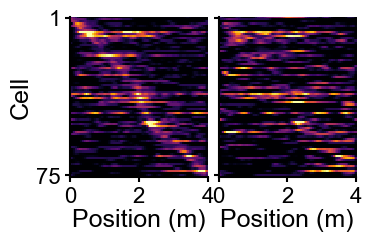

In [4]:
def display_tuning(tuning_list, ctx=np.array([0,1,0,1]), sort=0):
    
    nctx = len(set(ctx))
    tuning_mean = [[] for _ in range(nctx)]
    mice = range(len(tuning_list))

    for c in range(nctx):
        for m in mice:
            tuning = tuning_list[m]
            M = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)
            tuning_mean[c].append(M.mean(axis=2))
            
        tuning_mean[c] = np.vstack(tuning_mean[c])
    vmax = np.percentile(np.stack(tuning_mean),99.5)
    
    fig, axs = plt.subplots(1,nctx,figsize=(4,2.7),sharey=True,sharex=True)  # figsize (4,4.2) or (4,2.7)
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    for c in range(nctx):
        axs[c].imshow(tuning_mean[c][order], cmap='inferno', interpolation='none',
                      vmin=0, vmax=vmax, extent=[0,4,ncell+0.5,0.5])
    for ax in axs:
        ax.set_aspect('auto')
        ax.set_xlabel('Position (m)')
    axs[0].set(xticks=[0,2,4], xticklabels=[0,2,4], 
               yticks=[1,ncell], yticklabels=[1,ncell], ylabel='Cell')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.08)
    
    return fig

fig = display_tuning(tuning_pc_list, ctx=ctx, sort=0)
# fig.savefig('Tuning similar.svg')

In [5]:
def analyze_remapping(tuning_list, pc_list, day=1, days=np.array([1,1,1,1]), ctx=np.array([0,1,0,1])):
    
    n_mice = len(tuning_list)
    nctx = len(set(ctx))
    
    tuning_ctx = [[] for _ in range(nctx)]  # Average Fam/Nov
    for c in range(nctx):
        ks = np.where((days==day) & (ctx==c))[0]
        tuning = [[] for _ in range(n_mice)]  # All
        tuning0 = [[] for _ in range(n_mice)]  # Even
        tuning1 = [[] for _ in range(n_mice)]  # Odd
        for m in range(n_mice):
            pc = pc_list[m]  # PC in Fam or Nov
            M = np.concatenate([tuning_list[m][k][pc] for k in ks], axis=2)
            tuning[m] = M.mean(axis=2)
            tuning0[m] = M[:,:,0::2].mean(axis=2)  # Average even trials
            tuning1[m] = M[:,:,1::2].mean(axis=2)  # Average odd trials
        tuning_ctx[c] = np.vstack(tuning)
        if c == 0:  # Fam even/odd
            tuning_fam = [np.vstack(tuning0), np.vstack(tuning1)]
        elif c == 1:  # Nov even/odd
            tuning_nov = [np.vstack(tuning0), np.vstack(tuning1)]
    
    R_ff = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_fam[0], tuning_fam[1])])
    R_nn = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_nov[0], tuning_nov[1])])
    R_fn = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_ctx[0], tuning_ctx[1])])
    
    return np.vstack([R_ff, R_nn, R_fn])  # (3, ncell)

In [6]:
exps = ['Enriched','Dissimilar','Similar']
day = 1
min_rate = 1/60
pval_thr = 0.05
R_remapping = []

for p, exp in enumerate(exps):
    
    print('Get %s datasets ...' % exp)
    tuning_list = []
    pc_list = []  # Place cells
    
    for datapath in alldata[exp]:
    
        data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
        with h5py.File(datapath, 'r') as f:
            yrange = f['params/yrange'][()]  # Dataset dependent
            
        tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma, spike=False, transient=True)
        tuning_list.append(tuning)
        
        significant = (cells['si_pvalue'] <= pval_thr).T  # (nctx*nday, ncell)
        place_cells = np.any(significant, axis=0)
        pc_list.append(place_cells)
    
    R_remapping.append(
        analyze_remapping(tuning_list, pc_list, day=day, days=days, ctx=ctx))

Get Enriched datasets ...


C:\ProgramData\Anaconda3\envs\neurokit\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Get Dissimilar datasets ...
Get Similar datasets ...


----------------Enriched----------------
Kruskal-Wallis test, p-value: 7.001e-20
Post-hoc Dunn's test
FF vs NN p-value: 0.6773
FF vs FN p-value: 8.001e-12
NN vs FN p-value: 2.163e-16
----------------Dissimilar----------------
Kruskal-Wallis test, p-value: 8.453e-10
Post-hoc Dunn's test
FF vs NN p-value: 0.3511
FF vs FN p-value: 1.018e-08
NN vs FN p-value: 4.444e-05
----------------Similar----------------
Kruskal-Wallis test, p-value: 0.03701
Post-hoc Dunn's test
FF vs NN p-value: 0.04246
FF vs FN p-value: 0.6286
NN vs FN p-value: 0.6571
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Dissimilar_NN vs. Dissimilar_FN: Custom statistical test, P_val:4.444e-05
Similar_FF vs. Similar_NN: Custom statistical test, P_val:4.246e-02
Similar_NN vs. Similar_FN: Custom statistical test, P_val:6.571e-01
Enriched_FF vs. Enriched_NN: Custom statistical test, P_val:6.773e-01
Enriched_NN vs. Enriched_FN: Cu

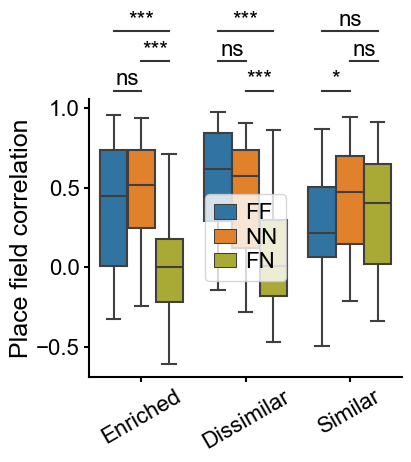

In [7]:
def compare_multiple(data_list, varnames=['A','B','C'], varvalues=[None,None,None],
                     palette=['tab:blue','tab:orange','tab:olive']):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    n_exp = len(data_list)
    df = ut.long_dataframe(data_list, varnames=varnames, varvalues=varvalues)
    struct = {'data':df, 'x':varnames[0], 'y':varnames[2], 'hue':varnames[1]}

    fig, ax = plt.subplots(figsize=(4.4,5.2))
    sns.boxplot(**struct, palette=palette, whis=(1,99), showfliers=False)
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    pairs, pvalues = [], []
    for p in range(n_exp):
        stat, pval = stats.kruskal(*data_list[p], nan_policy='omit')
        print('-'*16 + varvalues[0][p] + '-'*16)
        print('Kruskal-Wallis test, p-value: %.4g' % pval)
        pval_paired = posthoc_dunn(data_list[p], p_adjust='bonferroni').to_numpy()
        print('Post-hoc Dunn\'s test')
        print('FF vs NN p-value: %.4g' % pval_paired[0,1])
        print('FF vs FN p-value: %.4g' % pval_paired[0,2])
        print('NN vs FN p-value: %.4g' % pval_paired[1,2])
        for u, v in zip([0,0,1],[1,2,2]):
            pairs.append(((varvalues[0][p],varvalues[1][u]),
                          (varvalues[0][p],varvalues[1][v])))
            pvalues.append(pval_paired[u,v])
            
    annot = Annotator(ax, pairs, **struct)
    annot.configure(test=None, loc='outside', line_width=lwidth, line_height=0., pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
    
    ax.set_xticklabels(varvalues[0], rotation=30)
    ax.set(xlabel='', ylabel='Place field correlation')
    ax.legend(loc='best')
    fig.tight_layout()
    
    return fig

fig = compare_multiple(R_remapping, varnames=['Experiment','Data','Correlation'],
                       varvalues=[exps,['FF','NN','FN'],None])
# fig.savefig('Place field correlation.svg')

C:\Users\Hung-Ling\AppData\Local\Temp\ipykernel_4124\342886172.py:6: RuntimeWarning: Mean of empty slice
  remapping = [np.nanmean(R[0:2,:], axis=0)-R[2] for R in R_remapping]  # mean(FF,NN)-FN


Kruskal-Wallis test, p-value: 1.575e-13
Post-hoc Dunn's test
Enriched vs Dissimilar p-value: 1
Enriched vs Similar p-value: 3.148e-12
Dissimilar vs Similar p-value: 2.344e-08
--------------------------------
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Enriched vs. Dissimilar: Custom statistical test, P_val:1.000e+00
Dissimilar vs. Similar: Custom statistical test, P_val:2.344e-08
Enriched vs. Similar: Custom statistical test, P_val:3.148e-12


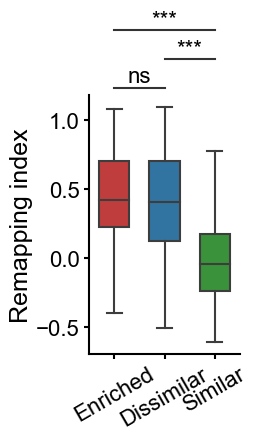

In [8]:
def summary_remapping(R_remapping, exps=['Enriched','Dissimilar','Similar'], colors=['tab:red','tab:blue','tab:green']):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    n_exp = len(exps)
    remapping = [np.nanmean(R[0:2,:], axis=0)-R[2] for R in R_remapping]  # mean(FF,NN)-FN
    
    df = pd.DataFrame({'Remapping': np.hstack(remapping),
                       'Experiment': np.hstack([np.repeat(exps[p], len(remapping[p]))
                                                for p in range(n_exp)])})
    
    fig, ax = plt.subplots(figsize=(2.9,5))
    sns.boxplot(data=df, x='Experiment', y='Remapping', ax=ax, width=0.6, palette=colors, whis=(1,99), showfliers=False)
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    pairs, pvalues = [], []
    
    stat, pval = stats.kruskal(*remapping, nan_policy='omit')
    print('Kruskal-Wallis test, p-value: %.4g' % pval)
    pval_paired = posthoc_dunn(remapping, p_adjust='bonferroni').to_numpy()
    print('Post-hoc Dunn\'s test')
    for u, v in zip([0,0,1],[1,2,2]):
        pairs.append((exps[u], exps[v]))
        pvalues.append(pval_paired[u,v])
        print(f'{exps[u]} vs {exps[v]} p-value: {pval_paired[u,v]:.4g}')
    print('-'*32)
    
    annot = Annotator(ax, pairs, data=df, x='Experiment', y='Remapping')
    annot.configure(test=None, loc='outside', line_width=lwidth, line_height=0., pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
    
    ax.set_xticklabels(exps, rotation=30)
    ax.set(xlabel='', ylabel='Remapping index')
    fig.tight_layout()
    
    return fig

fig = summary_remapping(R_remapping)
# fig.savefig('Remapping index.svg')

In [25]:
remapping = [np.nanmean(R[0:2,:], axis=0)-R[2] for R in R_remapping]  # mean(FF,NN)-FN
remapping = [r[np.isfinite(r)] for r in remapping]
exps=['Enriched','Dissimilar','Similar']

for p, exp in enumerate(exps):
    # pval = stats.ttest_1samp(remapping[p], 0)[1]  # alternative='greater'
    # print(f't-test for remapping index equal 0: p={pval:.4g}')
    pval = stats.mannwhitneyu(remapping[p], np.zeros_like(remapping[p]), alternative='greater')[1]  # alternative='greater'
    print(f'Mann-Whitney U test for remapping index not greater than 0: p={pval:.4g}')

Mann-Whitney U test for remapping index not greater than 0: p=6.857e-24
Mann-Whitney U test for remapping index not greater than 0: p=8.178e-13
Mann-Whitney U test for remapping index not greater than 0: p=0.8579


C:\Users\Hung-Ling\AppData\Local\Temp\ipykernel_4124\1676251111.py:1: RuntimeWarning: Mean of empty slice
  remapping = [np.nanmean(R[0:2,:], axis=0)-R[2] for R in R_remapping]  # mean(FF,NN)-FN
